In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
from torchvision.models import ShuffleNet_V2_X1_5_Weights
from torchvision.models import EfficientNet_B0_Weights

# Without Grad-Cam features

Fold 1/5


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 92.9MB/s]
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1_5-3c479a10.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1_5-3c479a10.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 158MB/s]


Epoch 1/6, Train Loss: 0.3953, Train Acc: 89.40%, Val Loss: 0.0994, Val Acc: 98.07%, Precision: 0.9830, Recall: 0.9839, F1 Score: 0.9834
Epoch 2/6, Train Loss: 0.1572, Train Acc: 96.13%, Val Loss: 0.0629, Val Acc: 98.77%, Precision: 0.9907, Recall: 0.9887, F1 Score: 0.9895
Epoch 3/6, Train Loss: 0.1617, Train Acc: 96.83%, Val Loss: 0.0449, Val Acc: 98.95%, Precision: 0.9921, Recall: 0.9904, F1 Score: 0.9911
Epoch 4/6, Train Loss: 0.1562, Train Acc: 96.13%, Val Loss: 0.0649, Val Acc: 97.89%, Precision: 0.9756, Recall: 0.9798, F1 Score: 0.9776
Epoch 5/6, Train Loss: 0.1535, Train Acc: 96.26%, Val Loss: 0.1304, Val Acc: 96.84%, Precision: 0.9776, Recall: 0.9653, F1 Score: 0.9705
Epoch 6/6, Train Loss: 0.1511, Train Acc: 96.44%, Val Loss: 0.0963, Val Acc: 97.01%, Precision: 0.9785, Recall: 0.9674, F1 Score: 0.9722
Fold 2/5
Epoch 1/6, Train Loss: 0.3100, Train Acc: 90.81%, Val Loss: 0.2172, Val Acc: 94.55%, Precision: 0.9277, Recall: 0.9530, F1 Score: 0.9380
Epoch 2/6, Train Loss: 0.2281, T

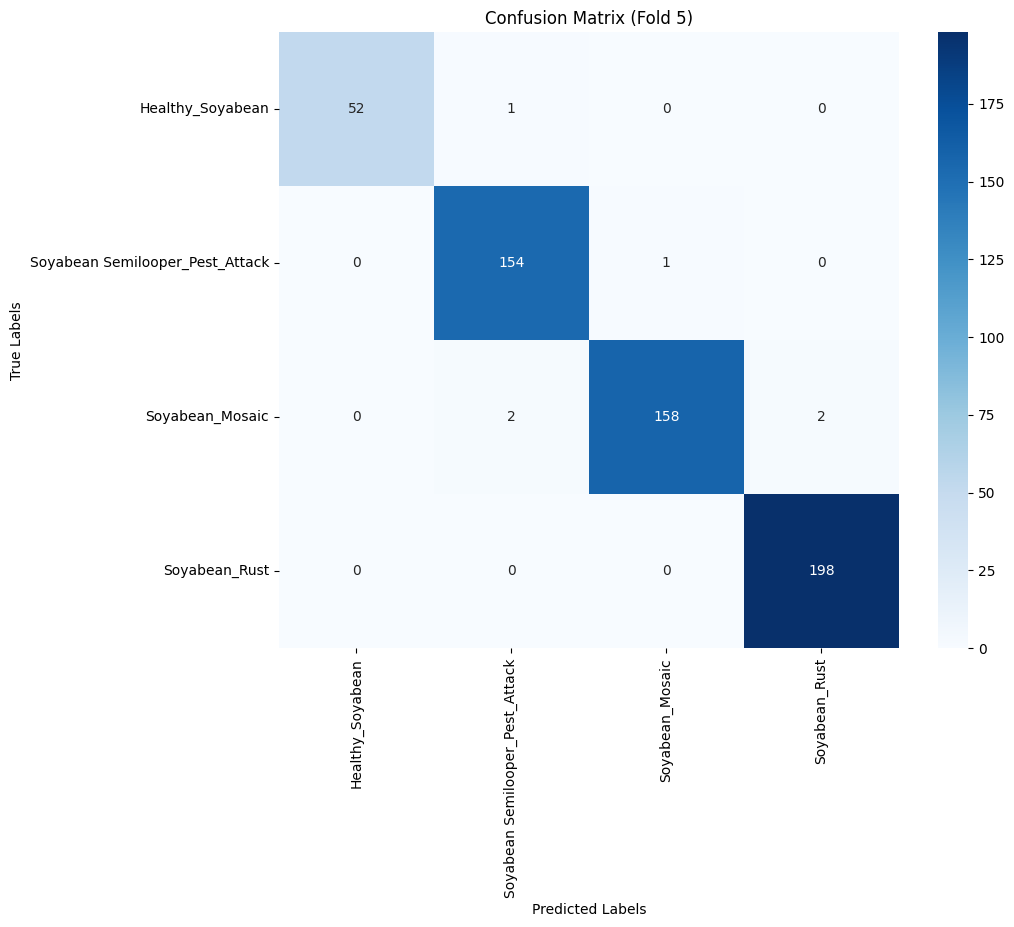

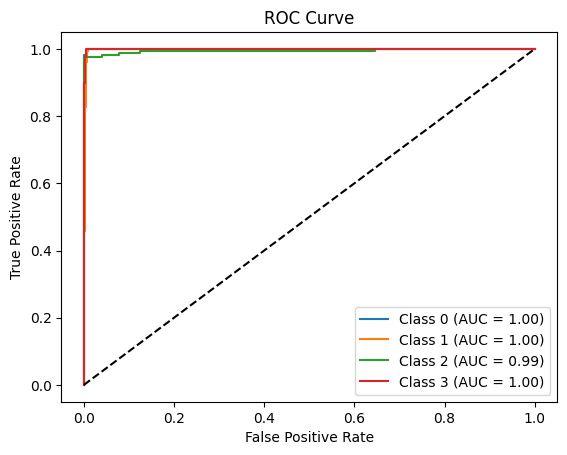

In [3]:
# Define the PND-Net architecture with advanced GCN and ensemble CNN
class PNDNet(nn.Module):
    def __init__(self, num_classes=5):
        super(PNDNet, self).__init__()
        # Load pre-trained EfficientNet-B0 and ShuffleNetV2 1.5
        self.efficientnet = models.efficientnet_b0(weights = EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.efficientnet.classifier = nn.Identity()  # Remove the final classification layer
        self.shufflenet = models.shufflenet_v2_x1_5(weights = ShuffleNet_V2_X1_5_Weights.IMAGENET1K_V1)
        self.shufflenet.fc = nn.Identity()  # Remove the final classification layer

        # Feature dimensions
        self.efficientnet_feature_dim = 1280
        self.shufflenet_feature_dim = 1024
        self.total_feature_dim = self.efficientnet_feature_dim + self.shufflenet_feature_dim

        # Spatial Pyramid Pooling (SPP)
        self.spp = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )

        # Graph Convolutional Network (GCN) with attention and skip connections
        self.gcn1 = nn.Sequential(
            nn.Linear(self.total_feature_dim, 1024),
            # nn.BatchNorm1d(1024),
            nn.LayerNorm(1024),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.gcn2 = nn.Sequential(
            nn.Linear(1024, 1024),
            # nn.BatchNorm1d(1024),
            nn.LayerNorm(1024),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.attention = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.Sigmoid()
        )

        # Classification head
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        # Extract features using EfficientNet-B0 and ShuffleNetV2 1.5
        features_eff = self.efficientnet(x)
        features_shuffle = self.shufflenet(x)
        
        # Apply Spatial Pyramid Pooling (SPP)
        features_eff = self.spp(features_eff.unsqueeze(-1).unsqueeze(-1))
        features_shuffle = self.spp(features_shuffle.unsqueeze(-1).unsqueeze(-1))
        
        # Concatenate features from both backbones
        features = torch.cat((features_eff, features_shuffle), dim=1)
        
        # Pass through GCN layers with attention
        x = self.gcn1(features)
        attention_weights = self.attention(x)
        x = x * attention_weights  # Apply attention
        x = self.gcn2(x) + x  # Skip connection
        
        # Classification
        x = self.fc(x)
        return x

# Data preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(25),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the Neem leaf dataset
dataset = ImageFolder(root='/kaggle/input/soyabin-drone-images/Soyabin', transform=transform)

# Define hyperparameters
num_epochs = 6
batch_size = 16
learning_rate = 0.001
num_classes = 4
k_folds = 5

# Initialize KFold cross-validation
kfold = KFold(n_splits=k_folds, shuffle=True)

# Store results for each fold
results = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
val_accuracies = []  # List to store validation accuracies for each fold
val_precisions = []  # List to store precision scores for each fold
val_recalls = []     # List to store recall scores for each fold
val_f1_scores = []   # List to store F1 scores for each fold

# Perform 5-fold cross-validation
for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f"Fold {fold + 1}/{k_folds}")
    
    # Subset the dataset for this fold
    train_subsampler = Subset(dataset, train_ids)
    val_subsampler = Subset(dataset, val_ids)
    
    # Create data loaders
    train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)
    
    # Initialize the model, loss function, and optimizer
    model = PNDNet(num_classes=num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training and validation loop
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        
        # Training phase
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_loss /= len(train_loader)
        train_acc = 100 * train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        all_preds = []
        all_labels = []
        all_probs = []
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
        
        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total

        # Calculate precision, recall, and F1 score
        precision = precision_score(all_labels, all_preds, average='macro')  # Macro average
        recall = recall_score(all_labels, all_preds, average='macro')       # Macro average
        f1 = f1_score(all_labels, all_preds, average='macro')              # Macro average
        
        # Store results
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['val_loss'].append(val_loss)
        results['val_acc'].append(val_acc)

        # Store metrics for this fold
        val_accuracies.append(val_acc)
        val_precisions.append(precision)
        val_recalls.append(recall)
        val_f1_scores.append(f1)
        
        # print(f"Epoch {epoch + 1}/{num_epochs}, "
        #       f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
        #       f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, "
              f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Plot confusion matrix for the last fold
    # if fold == k_folds - 1:
    #     cm = confusion_matrix(all_labels, all_preds)
    #     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
    #     disp.plot(cmap=plt.cm.Blues)
    #     plt.title(f"Confusion Matrix (Fold {fold + 1})")
    #     plt.show()

    # Plot confusion matrix for the last fold
    if fold == k_folds - 1:
        cm = confusion_matrix(all_labels, all_preds)
        # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
        # disp.plot(cmap=plt.cm.Blues)
        # plt.title(f"Confusion Matrix (Fold {fold + 1})")
        # plt.show()
    
        # Create a heatmap using seaborn
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=dataset.classes, yticklabels=dataset.classes)

         # Add labels and title
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix (Fold {fold + 1})')
        plt.show()

        # Plot ROC curve
        all_labels_bin = label_binarize(all_labels, classes=np.arange(num_classes))
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], np.array(all_probs)[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        plt.figure()
        for i in range(num_classes):
            plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

In [4]:
# Calculate and print the average metrics
average_val_accuracy = np.mean(val_accuracies)
average_precision = np.mean(val_precisions)
average_recall = np.mean(val_recalls)
average_f1_score = np.mean(val_f1_scores)

print(f"Average Validation Accuracy across all folds: {average_val_accuracy:.2f}%")
print(f"Average Precision across all folds: {average_precision:.4f}")
print(f"Average Recall across all folds: {average_recall:.4f}")
print(f"Average F1 Score across all folds: {average_f1_score:.4f}")

Average Validation Accuracy across all folds: 97.61%
Average Precision across all folds: 0.9786
Average Recall across all folds: 0.9732
Average F1 Score across all folds: 0.9742


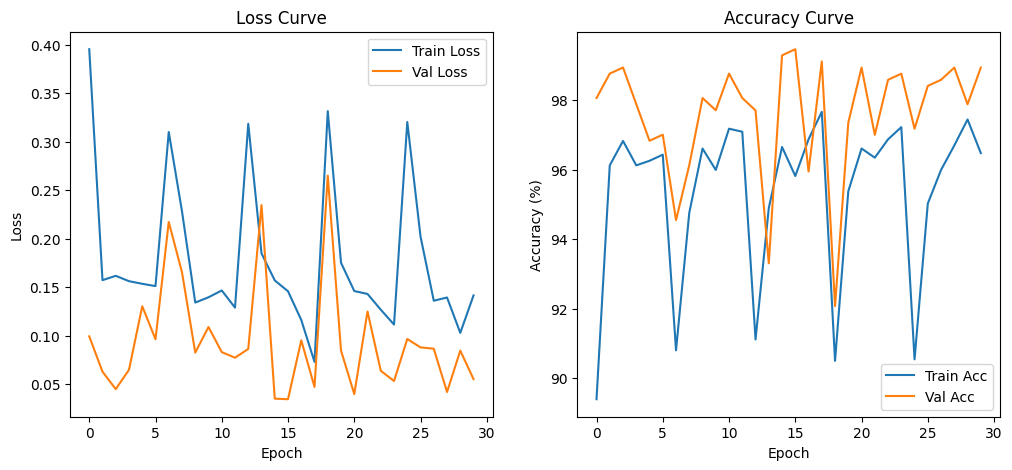

In [5]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(results['train_loss'], label='Train Loss')
plt.plot(results['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(results['train_acc'], label='Train Acc')
plt.plot(results['val_acc'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

# With Grad-Cam features

In [6]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, Subset
# from torchvision import transforms, models
# from sklearn.model_selection import KFold
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
# from sklearn.preprocessing import label_binarize
# import numpy as np
# import matplotlib.pyplot as plt
# from torchvision.datasets import ImageFolder
# import cv2

In [7]:
# # Define the PND-Net architecture with advanced GCN and ensemble CNN
# class PNDNet(nn.Module):
#     def __init__(self, num_classes=5):
#         super(PNDNet, self).__init__()
#         # Load pre-trained EfficientNet-B0 and ShuffleNetV2 1.5
#         self.efficientnet = models.efficientnet_b0(pretrained=True)
#         self.efficientnet.classifier = nn.Identity()  # Remove the final classification layer
#         self.shufflenet = models.shufflenet_v2_x1_5(pretrained=True)
#         self.shufflenet.fc = nn.Identity()  # Remove the final classification layer

#         # Feature dimensions
#         self.efficientnet_feature_dim = 1280
#         self.shufflenet_feature_dim = 1024
#         self.total_feature_dim = self.efficientnet_feature_dim + self.shufflenet_feature_dim

#         # Spatial Pyramid Pooling (SPP)
#         self.spp = nn.Sequential(
#             nn.AdaptiveAvgPool2d((1, 1)),
#             nn.Flatten()
#         )

#         # Graph Convolutional Network (GCN) with attention and skip connections
#         self.gcn1 = nn.Sequential(
#             nn.Linear(self.total_feature_dim, 1024),
#             nn.BatchNorm1d(1024),
#             nn.ReLU(),
#             nn.Dropout(0.5)
#         )
#         self.gcn2 = nn.Sequential(
#             nn.Linear(1024, 1024),
#             nn.BatchNorm1d(1024),
#             nn.ReLU(),
#             nn.Dropout(0.5)
#         )
#         self.attention = nn.Sequential(
#             nn.Linear(1024, 1024),
#             nn.Sigmoid()
#         )

#         # Classification head
#         self.fc = nn.Linear(1024, num_classes)

#     def forward(self, x):
#         # Extract features using EfficientNet-B0
#         features_eff = self.efficientnet.features(x)
        
#         # Extract features using ShuffleNetV2 1.5
#         x_shuffle = self.shufflenet.conv1(x)
#         x_shuffle = self.shufflenet.maxpool(x_shuffle)
#         x_shuffle = self.shufflenet.stage2(x_shuffle)
#         x_shuffle = self.shufflenet.stage3(x_shuffle)
#         x_shuffle = self.shufflenet.stage4(x_shuffle)
#         features_shuffle = self.shufflenet.conv5(x_shuffle)
        
#         # Apply Spatial Pyramid Pooling (SPP)
#         features_eff = self.spp(features_eff)
#         features_shuffle = self.spp(features_shuffle)
        
#         # Concatenate features from both backbones
#         features = torch.cat((features_eff, features_shuffle), dim=1)
        
#         # Pass through GCN layers with attention
#         x = self.gcn1(features)
#         attention_weights = self.attention(x)
#         x = x * attention_weights  # Apply attention
#         x = self.gcn2(x) + x  # Skip connection
        
#         # Classification
#         x = self.fc(x)
#         return x

# # Grad-CAM function
# def grad_cam(model, image, target_class):
#     model.eval()
#     image.requires_grad = True

#     # Forward pass
#     output = model(image)
#     model.zero_grad()

#     # Backward pass for the target class
#     output[:, target_class].backward()

#     # Get gradients and feature maps
#     gradients = model.gradients.detach().cpu().numpy()[0]
#     feature_maps = model.feature_maps.detach().cpu().numpy()[0]

#     # Compute Grad-CAM
#     weights = np.mean(gradients, axis=(1, 2))
#     cam = np.zeros(feature_maps.shape[1:], dtype=np.float32)
#     for i, w in enumerate(weights):
#         cam += w * feature_maps[i, :, :]

#     # Apply ReLU and normalize
#     cam = np.maximum(cam, 0)
#     cam = cv2.resize(cam, (image.shape[2], image.shape[3]))
#     cam = cam - np.min(cam)
#     cam = cam / np.max(cam)
#     return cam

# # Data preprocessing and augmentation
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     # transforms.RandomHorizontalFlip(),
#     # transforms.RandomRotation(25),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Load the Neem leaf dataset
# dataset = ImageFolder(root='/kaggle/input/black-gram-plant-leaf-disease/BPLD', transform=transform)

# # Define hyperparameters
# num_epochs = 20
# batch_size = 16
# learning_rate = 0.001
# num_classes = 5
# k_folds = 5

# # Initialize KFold cross-validation
# kfold = KFold(n_splits=k_folds, shuffle=True)

# # Store results for each fold
# results = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# # Perform 5-fold cross-validation
# for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
#     print(f"Fold {fold + 1}/{k_folds}")
    
#     # Subset the dataset for this fold
#     train_subsampler = Subset(dataset, train_ids)
#     val_subsampler = Subset(dataset, val_ids)
    
#     # Create data loaders
#     train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)
    
#     # Initialize the model, loss function, and optimizer
#     model = PNDNet(num_classes=num_classes)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
#     # Training and validation loop
#     for epoch in range(num_epochs):
#         model.train()
#         train_loss, train_correct, train_total = 0, 0, 0
        
#         # Training phase
#         for images, labels in train_loader:
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             train_loss += loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             train_total += labels.size(0)
#             train_correct += (predicted == labels).sum().item()
        
#         train_loss /= len(train_loader)
#         train_acc = 100 * train_correct / train_total
        
#         # Validation phase
#         model.eval()
#         val_loss, val_correct, val_total = 0, 0, 0
#         all_preds = []
#         all_labels = []
#         all_probs = []
#         with torch.no_grad():
#             for images, labels in val_loader:
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
                
#                 val_loss += loss.item()
#                 _, predicted = torch.max(outputs.data, 1)
#                 val_total += labels.size(0)
#                 val_correct += (predicted == labels).sum().item()
                
#                 all_preds.extend(predicted.cpu().numpy())
#                 all_labels.extend(labels.cpu().numpy())
#                 all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
        
#         val_loss /= len(val_loader)
#         val_acc = 100 * val_correct / val_total
        
#         # Store results
#         results['train_loss'].append(train_loss)
#         results['train_acc'].append(train_acc)
#         results['val_loss'].append(val_loss)
#         results['val_acc'].append(val_acc)
        
#         print(f"Epoch {epoch + 1}/{num_epochs}, "
#               f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
#               f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

#     # Plot confusion matrix for the last fold
#     if fold == k_folds - 1:
#         cm = confusion_matrix(all_labels, all_preds)
#         disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
#         disp.plot(cmap=plt.cm.Blues)
#         plt.title(f"Confusion Matrix (Fold {fold + 1})")
#         plt.show()

#         # Plot ROC curve
#         all_labels_bin = label_binarize(all_labels, classes=np.arange(num_classes))
#         fpr, tpr, roc_auc = {}, {}, {}
#         for i in range(num_classes):
#             fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], np.array(all_probs)[:, i])
#             roc_auc[i] = auc(fpr[i], tpr[i])
        
#         plt.figure()
#         for i in range(num_classes):
#             plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
#         plt.plot([0, 1], [0, 1], 'k--')
#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.title('ROC Curve')
#         plt.legend()
#         plt.show()

#         # Grad-CAM visualization for a sample image
#         sample_image, sample_label = next(iter(val_loader))
#         sample_image = sample_image[0].unsqueeze(0)
#         sample_label = sample_label[0].item()

#         # Get Grad-CAM
#         cam = grad_cam(model, sample_image, sample_label)

#         # Plot Grad-CAM
#         plt.figure()
#         plt.imshow(cam, cmap='jet', alpha=0.5)
#         plt.title(f"Grad-CAM for Class {sample_label}")
#         plt.axis('off')
#         plt.show()

In [8]:
# # Plot training and validation loss and accuracy
# plt.figure(figsize=(12, 5))

# # Plot loss
# plt.subplot(1, 2, 1)
# plt.plot(results['train_loss'], label='Train Loss')
# plt.plot(results['val_loss'], label='Val Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Loss Curve')
# plt.legend()

# # Plot accuracy
# plt.subplot(1, 2, 2)
# plt.plot(results['train_acc'], label='Train Acc')
# plt.plot(results['val_acc'], label='Val Acc')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy (%)')
# plt.title('Accuracy Curve')
# plt.legend()

# plt.show()